# Predicted vs Actual

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pandas import DataFrame
from sklearn.preprocessing import RobustScaler
from torch.utils.data import DataLoader
from tqdm import tqdm

import thesis_utils.datastruc as tuds
import thesis_utils.models as tum

In [2]:
# Model parameters
HORIZON = 1
BATCH_SIZE = 128
NUM_EPOCHS = 25
HIDDEN_SIZE = 128
N_LAYERS = 3
DROPOUT = 0.3
EMBEDDING_SIZE = 32

# Train parameters
TARGET = "EXPORT_centered"
FEATURES = [
  "contig", "comlang_off", "colony", "smctry",  # dist cepii categorical
]
N_SPLITS = 5
PATIENCE = 5
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.01
RANDOM_SEED = 16
KEEP_FRAC = 1.0
N_LAGS = 5
SUBSAMPLE_ENABLED = False
N_DYADS = 1000

SANCTION_COLS = ["arms", "military", "trade", "travel", "other"]

# Torch config
torch.manual_seed(RANDOM_SEED)
device = (
  torch.device("mps") if torch.backends.mps.is_available()
  else torch.device("cpu")
)

In [3]:
# GRU lr=0.01, dropout=0.2, hidden_size=128
checkpoint_gru = torch.load("../../models/GRU-0_01lr-0_2d-128hs.pt", map_location=torch.device("cpu"))

gru_model = tum.DyadGRU(**checkpoint_gru["model_hyperparams"])
gru_model.to(device)

DyadGRU(
  (dyad_embed): Embedding(33672, 32)
  (gru): GRU(52, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
processed = pd.read_parquet(path="../../data/model/processed.parquet", engine="fastparquet")
df: DataFrame = processed.copy(deep=True)

In [5]:
df["dyad_id"] = df["ISO3_reporter"] + "_" + df["ISO3_partner"]
df = df.sort_values(by=["dyad_id", "Year"], ignore_index=True)

In [6]:
df["sanction"] = (df[SANCTION_COLS]
                  .sum(axis=1)).astype(int)

In [7]:
num_cols = ["distw", "GDP_reporter", "GDP_partner", "sanction", "contig",
            "comlang_off", "colony", "smctry", "Year", ]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").astype(float)
df = df.dropna(subset=num_cols)

In [8]:
df["Year"] = df["Year"].astype(int)
for col in ["dyad_id"]:
  df[col] = pd.Categorical(df[col], categories=sorted(df[col].unique()))

In [9]:
center_columns = ["distw", "GDP_reporter", "GDP_partner", "EXPORT"]
for col in center_columns:
  median = df[col].median()
  std_df = df[col].std()
  df[col + "_centered"] = (df[col] - median) / std_df

FEATURES += ["distw_centered"]

In [10]:
lag_cols = ["GDP_reporter_centered", "GDP_partner_centered", "sanction"]
for col in lag_cols:
  for index in range(1, N_LAGS + 1):
    df[f"{col}_lag{index}"] = df.groupby("dyad_id", observed=True)[col].shift(index)

In [11]:
df = df.dropna()
FEATURES += [f"{c}_lag{index}" for c in lag_cols for index in range(1, N_LAGS + 1)]

In [12]:
gru_model.load_state_dict(checkpoint_gru["model_state_dict"])

<All keys matched successfully>

In [13]:
dataset, dyad_to_idx = tuds.make_panel_datasets_dyad_year(
  data=df,
  features=FEATURES,
  target=TARGET,
  horizon=HORIZON,
)

In [14]:
df

,ISO3_reporter,UNDS_reporter,CNAME_reporter,ISO3_partner,UNDS_partner,CNAME_partner,Year,GDP_reporter,GDP_partner,contig,...,GDP_partner_centered_lag1,GDP_partner_centered_lag2,GDP_partner_centered_lag3,GDP_partner_centered_lag4,GDP_partner_centered_lag5,sanction_lag1,sanction_lag2,sanction_lag3,sanction_lag4,sanction_lag5
5,AGO,024,Angola,ALB,008,Albania,1993,5.768720e+09,1.185315e+09,0.0,...,-0.012576,-0.012233,-0.011522,-0.011350,-0.011504,0.0,0.0,0.0,0.0,0.0
6,AGO,024,Angola,ALB,008,Albania,1994,4.438321e+09,1.880951e+09,0.0,...,-0.012167,-0.012576,-0.012233,-0.011522,-0.011350,0.0,0.0,0.0,0.0,0.0
7,AGO,024,Angola,ALB,008,Albania,1995,5.538749e+09,2.392765e+09,0.0,...,-0.011635,-0.012167,-0.012576,-0.012233,-0.011522,0.0,0.0,0.0,0.0,0.0
8,AGO,024,Angola,ALB,008,Albania,1996,7.526447e+09,3.199641e+09,0.0,...,-0.011243,-0.011635,-0.012167,-0.012576,-0.012233,0.0,0.0,0.0,0.0,0.0
9,AGO,024,Angola,ALB,008,Albania,1997,7.648377e+09,2.258514e+09,0.0,...,-0.010624,-0.011243,-0.011635,-0.012167,-0.012576,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178542,ZWE,716,Zimbabwe,ZMB,894,Zambia,2018,3.415607e+10,2.631151e+10,1.0,...,0.006744,0.002979,0.003204,0.007715,0.008402,0.0,0.0,0.0,0.0,0.0
1178543,ZWE,716,Zimbabwe,ZMB,894,Zambia,2019,2.571741e+10,2.330867e+10,1.0,...,0.007080,0.006744,0.002979,0.003204,0.007715,0.0,0.0,0.0,0.0,0.0
1178544,ZWE,716,Zimbabwe,ZMB,894,Zambia,2020,2.686794e+10,1.813776e+10,1.0,...,0.004780,0.007080,0.006744,0.002979,0.003204,0.0,0.0,0.0,0.0,0.0
1178545,ZWE,716,Zimbabwe,ZMB,894,Zambia,2021,2.724052e+10,2.209642e+10,1.0,...,0.000819,0.004780,0.007080,0.006744,0.002979,0.0,0.0,0.0,0.0,0.0


In [15]:
data_loader = DataLoader(
  dataset,
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=10,
  persistent_workers=True,
  prefetch_factor=2,
  pin_memory=False
)

In [16]:
gru_model.eval()
preds, truth, years_collected = [], [], []
with torch.no_grad():
  for X, y, di, yr in tqdm(data_loader, desc="Predicting", unit="batch"):
    X, di = map(lambda t: t.to(device, non_blocking=True), (X, di))
    y_hat = gru_model(X, di).cpu()
    preds.append(y_hat)
    truth.append(y)
    years_collected.append(yr)

preds = torch.cat(preds).numpy()
truth = torch.cat(truth).numpy()
years = torch.cat(years_collected).numpy()

Predicting: 100%|██████████| 7893/7893 [00:19<00:00, 413.80batch/s]


In [17]:
print("Preds stats (raw):", preds.min(), preds.max(), preds.mean())
print("Truth stats (raw):", truth.min(), truth.max(), truth.mean())

Preds stats (raw): -0.730263 51.99489 0.08080604
Truth stats (raw): 0.0 138.23305 0.07904376


In [18]:
plot_df = pd.DataFrame({
  "Year": years.flatten(),
  "Prediction": preds.flatten(),
  "Truth": truth.flatten()
})

In [19]:
robust_scalar = RobustScaler()
print(robust_scalar.fit_transform(df[["EXPORT"]]))

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ...
 [11.33310457]
 [12.95991877]
 [19.40603015]]


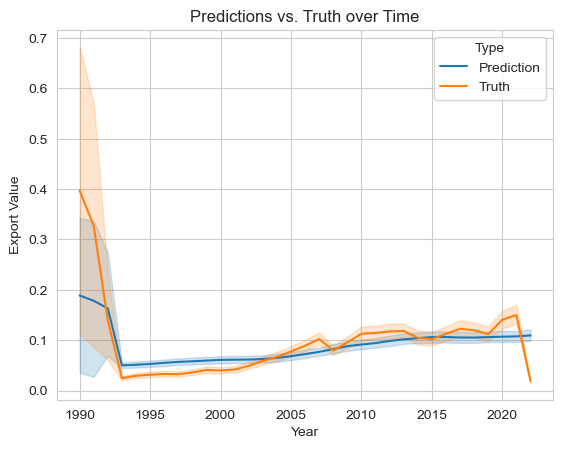

In [20]:
plot_df_melted = plot_df.melt(id_vars="Year", value_vars=["Prediction", "Truth"],
                              var_name="Type", value_name="Value")

sns.lineplot(data=plot_df_melted, x="Year", y="Value", hue="Type")
plt.title("Predictions vs. Truth over Time")
plt.ylabel("Export Value")
plt.show()

In [21]:
df

,ISO3_reporter,UNDS_reporter,CNAME_reporter,ISO3_partner,UNDS_partner,CNAME_partner,Year,GDP_reporter,GDP_partner,contig,...,GDP_partner_centered_lag1,GDP_partner_centered_lag2,GDP_partner_centered_lag3,GDP_partner_centered_lag4,GDP_partner_centered_lag5,sanction_lag1,sanction_lag2,sanction_lag3,sanction_lag4,sanction_lag5
5,AGO,024,Angola,ALB,008,Albania,1993,5.768720e+09,1.185315e+09,0.0,...,-0.012576,-0.012233,-0.011522,-0.011350,-0.011504,0.0,0.0,0.0,0.0,0.0
6,AGO,024,Angola,ALB,008,Albania,1994,4.438321e+09,1.880951e+09,0.0,...,-0.012167,-0.012576,-0.012233,-0.011522,-0.011350,0.0,0.0,0.0,0.0,0.0
7,AGO,024,Angola,ALB,008,Albania,1995,5.538749e+09,2.392765e+09,0.0,...,-0.011635,-0.012167,-0.012576,-0.012233,-0.011522,0.0,0.0,0.0,0.0,0.0
8,AGO,024,Angola,ALB,008,Albania,1996,7.526447e+09,3.199641e+09,0.0,...,-0.011243,-0.011635,-0.012167,-0.012576,-0.012233,0.0,0.0,0.0,0.0,0.0
9,AGO,024,Angola,ALB,008,Albania,1997,7.648377e+09,2.258514e+09,0.0,...,-0.010624,-0.011243,-0.011635,-0.012167,-0.012576,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178542,ZWE,716,Zimbabwe,ZMB,894,Zambia,2018,3.415607e+10,2.631151e+10,1.0,...,0.006744,0.002979,0.003204,0.007715,0.008402,0.0,0.0,0.0,0.0,0.0
1178543,ZWE,716,Zimbabwe,ZMB,894,Zambia,2019,2.571741e+10,2.330867e+10,1.0,...,0.007080,0.006744,0.002979,0.003204,0.007715,0.0,0.0,0.0,0.0,0.0
1178544,ZWE,716,Zimbabwe,ZMB,894,Zambia,2020,2.686794e+10,1.813776e+10,1.0,...,0.004780,0.007080,0.006744,0.002979,0.003204,0.0,0.0,0.0,0.0,0.0
1178545,ZWE,716,Zimbabwe,ZMB,894,Zambia,2021,2.724052e+10,2.209642e+10,1.0,...,0.000819,0.004780,0.007080,0.006744,0.002979,0.0,0.0,0.0,0.0,0.0


In [22]:
gru_model.eval()
preds, truth, years_collected = [], [], []
with torch.no_grad():
  for X, y, di, yr in tqdm(data_loader, desc="Predicting", unit="batch"):
    X, di = map(lambda t: t.to(device, non_blocking=True), (X, di))
    y_hat = gru_model(X, di).cpu()
    y_hat = (y_hat + 0.5) * (df["EXPORT"].max() - df["EXPORT"].min()) + df["EXPORT"].min()
    preds.append(y_hat)
    truth.append(y)
    years_collected.append(yr)

preds = torch.cat(preds).numpy()
truth = torch.cat(truth).numpy()
years = torch.cat(years_collected).numpy()

Predicting: 100%|██████████| 7893/7893 [00:49<00:00, 159.31batch/s]


In [23]:
dyad_id_to_plot = "ROM_AUT"
df_dyad = df[df["dyad_id"] == dyad_id_to_plot]
df_dyad = df_dyad.sort_values("Year")

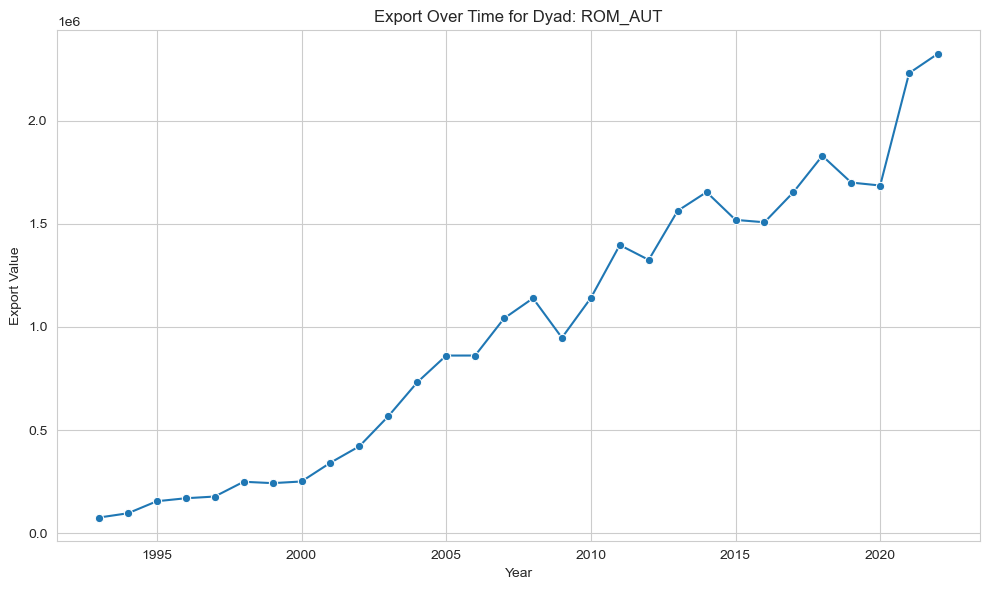

In [24]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_dyad, x="Year", y="EXPORT", marker="o")
plt.title(f"Export Over Time for Dyad: {dyad_id_to_plot}")
plt.xlabel("Year")
plt.ylabel("Export Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
dyad_idx_to_predict = dyad_to_idx["ROM_AUT"]
preds = []
truth = []
years_collected = []
with torch.no_grad():
  for X, y, di, yr in tqdm(data_loader, desc="Predicting", unit="batch"):
    mask = (di == dyad_idx_to_predict)
    if mask.any():
      X_masked = X[mask].to(device)
      di_masked = di[mask].to(device)
      y_masked = y[mask]
      yr_masked = yr[mask]

      y_hat = gru_model(X_masked, di_masked).cpu()

      preds.append(y_hat)
      truth.append(y_masked)
      years_collected.append(yr_masked)

# Concatenate at the end
preds = torch.cat(preds).numpy()
truth = torch.cat(truth).numpy()
years = torch.cat(years_collected).numpy()

Predicting: 100%|██████████| 7893/7893 [00:02<00:00, 3575.50batch/s]


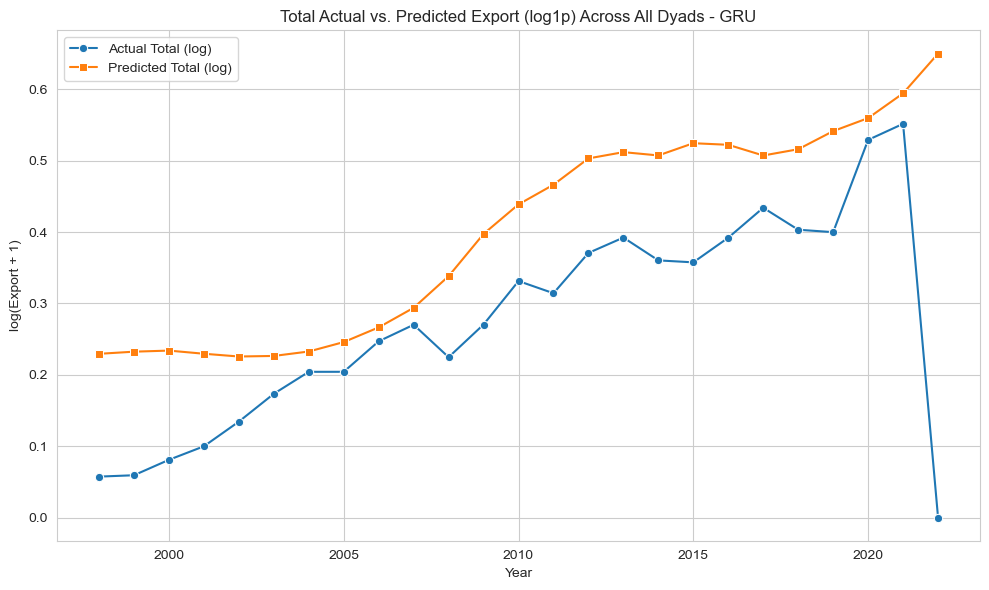

In [41]:
EXPORT_median = df["EXPORT"].median()
EXPORT_std = df["EXPORT"].std()
preds_original = preds * EXPORT_std + EXPORT_median

# 3. Assemble a DataFrame with years
plot_df = pd.DataFrame({
  "Year": years.flatten(),
  "Predicted_log": preds_original.flatten(),
  "Truth_log": truth.flatten(),
})

# 4. Aggregate by year
agg = plot_df.groupby("Year")[["Predicted_log", "Truth_log"]].sum().reset_index()
agg = agg[agg["Year"] >= 1998]

# 5. Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=agg, x="Year", y="Truth_log", label="Actual Total (log)", marker="o")
sns.lineplot(data=agg, x="Year", y="Predicted_log", label="Predicted Total (log)", marker="s")
plt.title("Total Actual vs. Predicted Export (log1p) Across All Dyads - GRU")
plt.xlabel("Year")
plt.ylabel("log(Export + 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

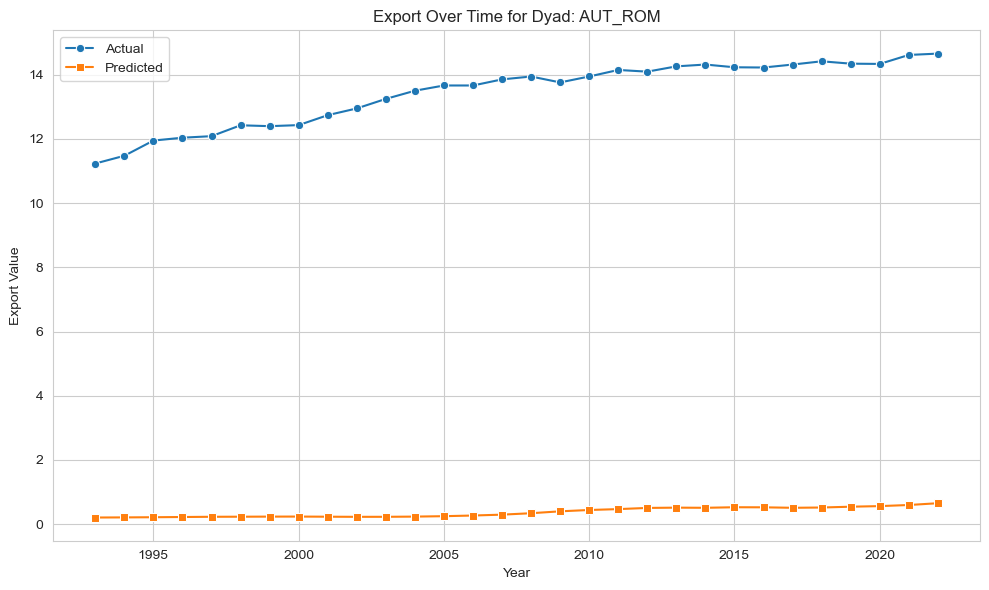

In [42]:
df_dyad = df_dyad.copy()  # Avoid modifying original
df_dyad["Predicted_EXPORT"] = preds_original.flatten()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
sns.lineplot(data=df[df["dyad_id"] == "ROM_AUT"], x="Year", y="EXPORT", label="Actual", marker="o")
sns.lineplot(data=df_dyad, x="Year", y="Predicted_EXPORT", label="Predicted", marker="s")
plt.title(f"Export Over Time for Dyad: {dyad_id_to_plot}")
plt.xlabel("Year")
plt.ylabel("Export Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
df_dyad.head(10)

,ISO3_reporter,UNDS_reporter,CNAME_reporter,ISO3_partner,UNDS_partner,CNAME_partner,Year,GDP_reporter,GDP_partner,contig,...,GDP_partner_centered_lag2,GDP_partner_centered_lag3,GDP_partner_centered_lag4,GDP_partner_centered_lag5,sanction_lag1,sanction_lag2,sanction_lag3,sanction_lag4,sanction_lag5,Predicted_EXPORT
884202,ROM,642,Romania,AUT,040,Austria,1993,2.636116e+10,1.896340e+11,0.0,...,0.119534,0.113941,0.088488,0.088666,0.0,0.0,0.0,0.0,0.0,0.041204
884203,ROM,642,Romania,AUT,040,Austria,1994,3.007281e+10,2.027380e+11,0.0,...,0.135775,0.119534,0.113941,0.088488,0.0,0.0,0.0,0.0,0.0,0.041995
884204,ROM,642,Romania,AUT,040,Austria,1995,3.743016e+10,2.400942e+11,0.0,...,0.132190,0.135775,0.119534,0.113941,0.0,0.0,0.0,0.0,0.0,0.043052
884205,ROM,642,Romania,AUT,040,Austria,1996,3.693707e+10,2.359526e+11,0.0,...,0.142228,0.132190,0.135775,0.119534,0.0,0.0,0.0,0.0,0.0,0.044436
884206,ROM,642,Romania,AUT,040,Austria,1997,3.557521e+10,2.117248e+11,0.0,...,0.170844,0.142228,0.132190,0.135775,0.0,0.0,0.0,0.0,0.0,0.045863
884207,ROM,642,Romania,AUT,040,Austria,1998,4.169609e+10,2.170681e+11,0.0,...,0.167671,0.170844,0.142228,0.132190,0.0,0.0,0.0,0.0,0.0,0.046333
884208,ROM,642,Romania,AUT,040,Austria,1999,3.595316e+10,2.164218e+11,0.0,...,0.149112,0.167671,0.170844,0.142228,0.0,0.0,0.0,0.0,0.0,0.046937
884209,ROM,642,Romania,AUT,040,Austria,2000,3.725374e+10,1.961816e+11,0.0,...,0.153205,0.149112,0.167671,0.170844,0.0,0.0,0.0,0.0,0.0,0.047244
884210,ROM,642,Romania,AUT,040,Austria,2001,4.039512e+10,1.964772e+11,0.0,...,0.152710,0.153205,0.149112,0.167671,0.0,0.0,0.0,0.0,0.0,0.046353
884211,ROM,642,Romania,AUT,040,Austria,2002,4.606550e+10,2.128372e+11,0.0,...,0.137205,0.152710,0.153205,0.149112,0.0,0.0,0.0,0.0,0.0,0.045573


In [29]:
df["GDP_reporter"] = np.log1p(df["GDP_reporter"]).astype(float)
df["GDP_partner"] = np.log1p(df["GDP_partner"]).astype(float)
df["EXPORT"] = np.log1p(df["EXPORT"])
df["sanction"] = (df[SANCTION_COLS]
                  .sum(axis=1)).astype(int)
df["distw"] = np.log1p(df["distw"]).astype(float)

In [30]:
beta_df = pd.read_csv("../../models/ppml_beta_values.csv", index_col=0)
beta_values = beta_df["beta"].values
model_columns = beta_df.index.tolist()

In [31]:
model_columns

['GDP_reporter_lag1',
 'GDP_reporter_lag2',
 'GDP_reporter_lag3',
 'GDP_reporter_lag4',
 'GDP_reporter_lag5',
 'GDP_partner_lag1',
 'GDP_partner_lag2',
 'GDP_partner_lag3',
 'GDP_partner_lag4',
 'GDP_partner_lag5',
 'sanction_lag1',
 'sanction_lag2',
 'sanction_lag3',
 'sanction_lag4',
 'sanction_lag5',
 'contig',
 'comlang_off',
 'colony',
 'smctry',
 'distw']

In [32]:
lag_cols = ["GDP_reporter", "GDP_partner", "sanction"]
for col in lag_cols:
  for index in range(1, N_LAGS + 1):
    df[f"{col}_lag{index}"] = df.groupby("dyad_id", observed=True)[col].shift(index)

In [33]:
X_test = df[model_columns].values  # df should contain these columns

# Step 2: Predict using dot product and exponentiate
linear_combination = X_test @ beta_values
df["EXPORT_hat"] = np.exp(linear_combination)  # Add prediction to original df

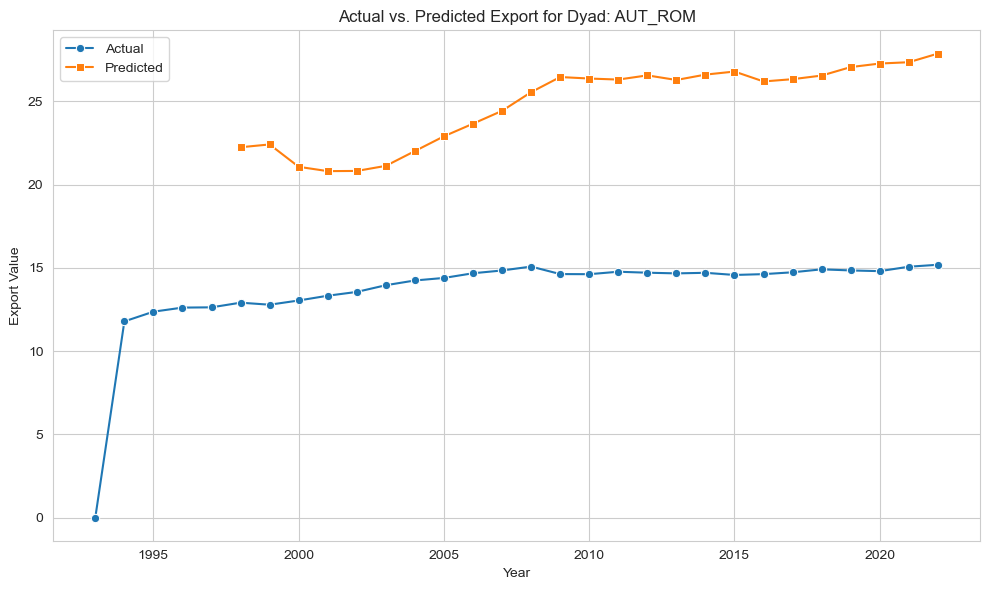

In [34]:
dyad_id_to_plot = "AUT_ROM"  # or any dyad ID you want
df_dyad = df[df["dyad_id"] == dyad_id_to_plot].copy()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_dyad, x="Year", y="EXPORT", label="Actual", marker="o")
sns.lineplot(data=df_dyad, x="Year", y="EXPORT_hat", label="Predicted", marker="s")
plt.title(f"Actual vs. Predicted Export for Dyad: {dyad_id_to_plot}")
plt.xlabel("Year")
plt.ylabel("Export Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

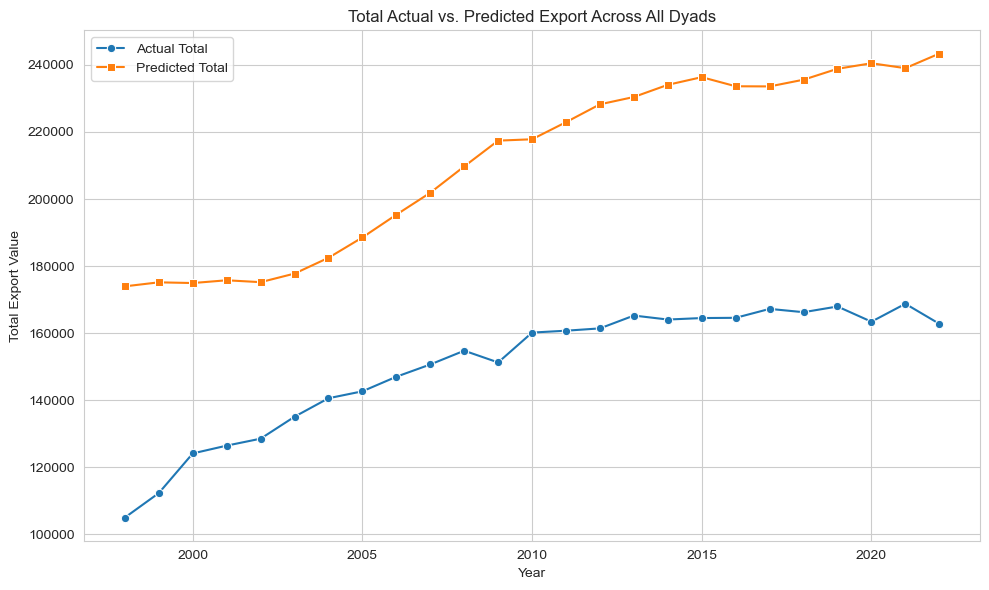

In [35]:
agg = df.groupby("Year")[["EXPORT", "EXPORT_hat"]].sum().reset_index()
agg = agg[agg["Year"] >= 1998]

plt.figure(figsize=(10, 6))
sns.lineplot(data=agg, x="Year", y="EXPORT", label="Actual Total", marker="o")
sns.lineplot(data=agg, x="Year", y="EXPORT_hat", label="Predicted Total", marker="s")
plt.title("Total Actual vs. Predicted Export Across All Dyads")
plt.xlabel("Year")
plt.ylabel("Total Export Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()